In [1]:
# Import package
import numpy as np
from numpy import random
import torch, os
from tqdm import tqdm
from tqdm import trange 
from multiprocessing import Pool
import pandas as pd
from transformers import BertModel, BertConfig, DNATokenizer
from Bio import SeqIO
from sklearn.model_selection import train_test_split as tts

ROOT = '/home/dell15/KING/Projects/202109_tfbind3/'
#seq_df = pd.read_csv(data, header=None)

print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lines = seq_df[0]
dir_to_pretrained_model = ROOT+'DNABERT/6-new-12w-0/'
config = BertConfig.from_pretrained('https://raw.githubusercontent.com/jerryji1993/DNABERT/master/src/transformers/dnabert-config/bert-config-6/config.json')
tokenizer = DNATokenizer.from_pretrained('dna6')
model = BertModel.from_pretrained(dir_to_pretrained_model, config=config)
model.to(device)

def getEmb(seq, n):
    seq_ = ' '.join([seq[i:i+n] for i in range(0, len(seq), n)])
    model_input = tokenizer.encode_plus(seq_, add_special_tokens=False, max_length=512)["input_ids"]
    model_input = torch.tensor(model_input, dtype=torch.long).to(device)
    model_input = model_input.unsqueeze(0)   # to generate a fake batch with batch size one
    output = model(model_input)
    return output[1]   

def onehotEncode(data):
    # define universe of possible input values
    bases = 'ATGC'
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(bases))
    int_to_char = dict((i, c) for i, c in enumerate(bases))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in data]
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(bases))]
        letter[value] = 1
        onehot_encoded.append(letter)
    #return list(map(list, zip(*onehot_encoded)))
    return(onehot_encoded)

# Encode data MASKED/GC CONTROLLED
def encode2(record):
    a = []
    count=0
    for i in tqdm(record):
        if count>=10000:
            break
        data = str(i.seq).upper()
        #if 35<checkGC(data)<45:
        try:
            a_ = onehotEncode(data)
            mask = [[0.5,0.5,0.5,0.5]]
            a_[int(len(a_)/2)-6:int(len(a_)/2)+6] = mask*abs((int(len(a_)/2)-6)-(int(len(a_)/2)+6))
            a.append(a_)
            count+=1
        except:
            pass
    return a

# Check GC
def checkGC(seq):
    return round((seq.count('C')+seq.count('G'))/len(seq)*100)

# BERT
def get_bert_emb(seqs):
    a, bert = [], []
    for seq in seqs:
        bert_ = getEmb((seq), 6)[0].detach().cpu().numpy().tolist()
        a_ = onehotEncode(seq)
        bert.append(bert_)
        a.append(a_)
    return bert, a

NVIDIA GeForce RTX 2080
<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
# Load Kmer dict and generate BERT embeddings
kmer_dict = np.load('kmer_dict_1000.npy', allow_pickle=True).item()
a, b = get_bert_emb(kmer_dict['MAX'])
X1 = np.array(a, dtype=float)
X2 = np.array(b)

In [103]:
# import matplotlib.pyplot as plt
# from Bio.Cluster import kcluster 
# import numpy as np
# import collections 

# N_CLUST = 5

# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2, perplexity=40, init='random', random_state=14).fit_transform(X2.reshape(1000,4*5))
# clusterid,error,found = kcluster(X_embedded, nclusters=N_CLUST) 
# print(collections.Counter(clusterid))
# plot= plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusterid, cmap='tab20')
# plt.legend(handles=plot.legend_elements()[0], labels=range(N_CLUST))
# # plt.show()

In [104]:
# X1: BERT EMBEEDINGS
from tqdm import tqdm
tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST', 'CTCF', 'FOSL2', 'JUN']
xemb_dict = dict.fromkeys(tfs, None)
cluster_dict = dict.fromkeys(tfs, None)
for TF in tqdm(tfs):
    a, b = get_bert_emb(kmer_dict[TF])
    X1 = np.array(a, dtype=float)
    
    N_CLUST = 10

    X_embedded = TSNE(n_components=2, perplexity=30, init='random').fit_transform(X1)
    clusterid,error,found = kcluster(X_embedded, nclusters=N_CLUST) 
    xemb_dict[TF]=X_embedded
    cluster_dict[TF]=clusterid

100%|██████████| 8/8 [01:40<00:00, 12.53s/it]


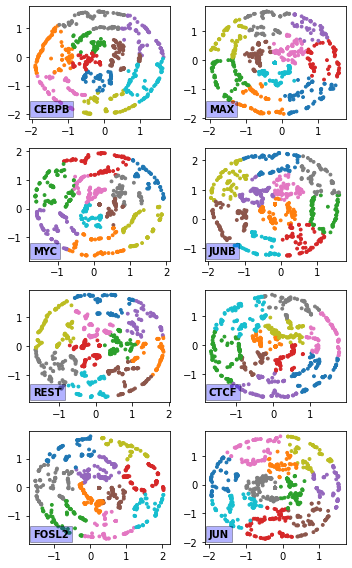

In [106]:
import matplotlib.pyplot as plt
from Bio.Cluster import kcluster 
import numpy as np
import collections 
from sklearn.manifold import TSNE

fig, axes = plt.subplots(4,2,figsize=(5,8))
tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST', 'CTCF', 'FOSL2', 'JUN']
for TF, ax in zip(tfs, axes.flatten()):
    X_embedded = xemb_dict[TF]
    clusterid = cluster_dict[TF]
    #print(collections.Counter(clusterid))
    plot = ax.scatter(X_embedded[:,0], X_embedded[:,1], s=8, c=clusterid, cmap='tab10')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2.1)
    #plt.legend(handles=plot.legend_elements()[0], labels=range(N_CLUST), ncol=2)
    ax.text(0.03, 0.06, TF, transform=ax.transAxes, fontweight='bold',bbox={'facecolor':'blue', 'alpha':0.3, 'pad':3})
fig.tight_layout()
plt.savefig('plot/kmers_tsne_cluster_bert.png', dpi=400, transparent=False, bbox_inches='tight') 
plt.show()

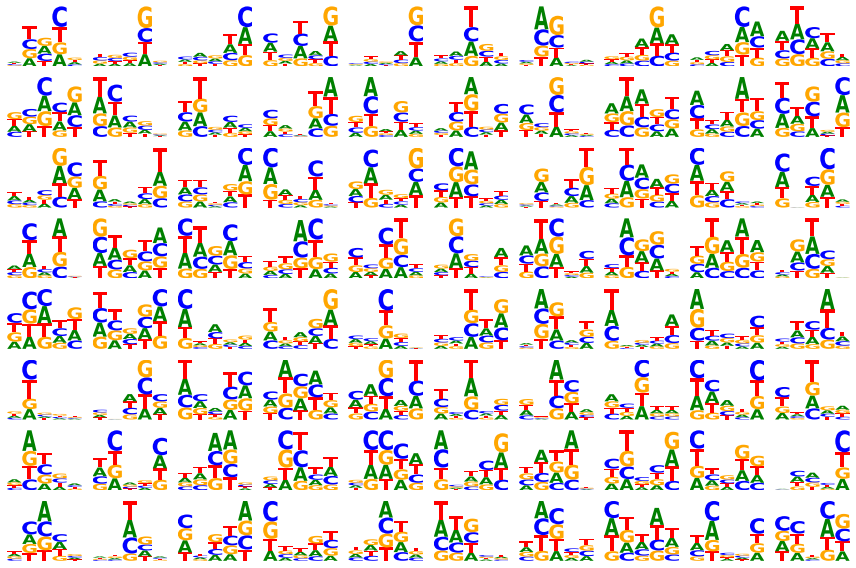

In [93]:
fig, axes = plt.subplots(8,10, figsize=(12,8), sharex=True)
kmer_df = pd.DataFrame.from_dict(kmer_dict)
for TF, ax_row in zip(tfs, axes):
    for cluster_id, ax in zip(range(N_CLUST), ax_row):
        cluster_kmers = kmer_df[TF][np.argwhere(cluster_dict[TF]==cluster_id).flatten()]
        kmer_array = []
        for kmer in cluster_kmers:
            kmer_array.append(list(kmer))
        kmer_array = np.array(kmer_array)
        kmer_array

        matrix = pd.DataFrame(columns=list('ACGT'), dtype=float)
        for i in range(5):
            counter = collections.Counter(kmer_array[:,i])
            matrix = matrix.append(counter, ignore_index=True)
        matrix.index.name = 'pos'

        # Plot logos
        info_mat = lm.transform_matrix(matrix, 
                                        from_type='counts', 
                                        to_type='information')
        logo = lm.Logo(info_mat, ax=ax, show_spines=False, color_scheme='classic')
        #ax.text(0.9, 0.9, cluster_id, transform=ax.transAxes, fontweight='bold',bbox={'facecolor':'red', 'alpha':0.3, 'pad':3})
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
fig.tight_layout()
#plt.savefig('plot/kmers_logomaker_cluster.png', dpi=400, transparent=False, bbox_inches='tight')

In [99]:
#X2: ONEHOT
from tqdm import tqdm
tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST', 'CTCF', 'FOSL2', 'JUN']
xemb_dict = dict.fromkeys(tfs, None)
cluster_dict = dict.fromkeys(tfs, None)
for TF in tqdm(tfs):
    a, b = get_bert_emb(kmer_dict[TF])
    X1 = np.array(b, dtype=float)
    
    N_CLUST = 10

    X_embedded = TSNE(n_components=2, perplexity=25, init='random').fit_transform(X2.reshape(1000,4*5))
    clusterid,error,found = kcluster(X_embedded, nclusters=N_CLUST) 
    xemb_dict[TF]=X_embedded
    cluster_dict[TF]=clusterid

100%|██████████| 8/8 [01:26<00:00, 10.79s/it]


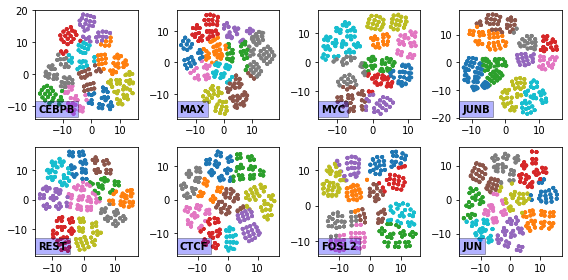

In [102]:
import matplotlib.pyplot as plt
from Bio.Cluster import kcluster 
import numpy as np
import collections 
from sklearn.manifold import TSNE

fig, axes = plt.subplots(2,4,figsize=(8,4))
tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST', 'CTCF', 'FOSL2', 'JUN']
for TF, ax in zip(tfs, axes.flatten()):
    X_embedded = xemb_dict[TF]
    clusterid = cluster_dict[TF]
    #print(collections.Counter(clusterid))
    plot = ax.scatter(X_embedded[:,0], X_embedded[:,1], s=8, c=clusterid, cmap='tab10')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2.1)
    #plt.legend(handles=plot.legend_elements()[0], labels=range(N_CLUST), ncol=2)
    ax.text(0.03, 0.06, TF, transform=ax.transAxes, fontweight='bold',bbox={'facecolor':'blue', 'alpha':0.3, 'pad':3})
fig.tight_layout()
plt.savefig('plot/kmers_tsne_cluster_onehot.png', dpi=400, transparent=False, bbox_inches='tight') 
plt.show()

In [14]:
sequence[np.argwhere(clusterid==0).flatten()]

Index(['GCTCG', 'AGCAG', 'GAGGA', 'CCGGA', 'CGTGC', 'GGGCA', 'AAAAA', 'AGGAG',
       'GGGAT', 'GACCC',
       ...
       'GTCAT', 'GTCAA', 'GTGCC', 'GTGCG', 'GGAGC', 'GGACT', 'GGGGT', 'GGTCA',
       'GGGGA', 'CCCGA'],
      dtype='object', length=750)

In [1]:
# Get Data statistics
import pandas as pd
from Bio import SeqIO

# data_path = '../data/15tf/15tf_fasta_1000_neg/CEBPB-human/'
# for bed_file in os.listdir(data_path):
#     print(bed_file)
#     entry = pd.read_csv(data_path+'/'+bed_file, sep='\t', header=None)
#     print(len(bed_file))
#     break
TF = 'CEBPB'
data_path = '../data/15tf/15tf_fasta_1000_neg/'
for i in os.listdir(data_path+'/'+TF+'-human'):
    record1 = SeqIO.parse(data_path+TF+"-human/"+i, "fasta")
    break

In [2]:
import collections

def checkGC(seq):
    return round((seq.count('C')+seq.count('G'))/len(seq)*100)

TF = 'CTCF'

metadata = pd.read_csv('../data/15tf/15tfs_data/metadata.tsv', sep='\t')
metadata = metadata[['File accession','Biosample term name', 'Experiment target']]
metadata_tf = metadata[metadata['Experiment target']==TF+'-human']
#metadata['Biosample term name'].unique()

fasta_path = '../data/15tf/15tf_fasta_1000_neg/'
gc = []
for file_acc in metadata_tf['File accession']:  
    record1 = SeqIO.parse(fasta_path+TF+"-human/"+file_acc+'.fa', "fasta")
    break
#collections.Counter(metadata_tf['Biosample term name'])


In [3]:
for i in record1:
    print(i)
    print(len(i.seq))
    break

ID: chr1:620048-621048
Name: chr1:620048-621048
Description: chr1:620048-621048
Number of features: 0
Seq('tgccttccaggaaggttataacaatttgcctgatccccagcagcaACAGACTTT...cca')
1000


In [1]:
import lib

ModuleNotFoundError: No module named 'lib'